Using Machine Learning for Forecasting Energy Consumption


This notebook is based on the **Hour Energy Consumption** Dataset on Kaggle
You can download the files here: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?resource=download

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

### Data Acquisition

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head(5)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


## Exploratory Data Analysis

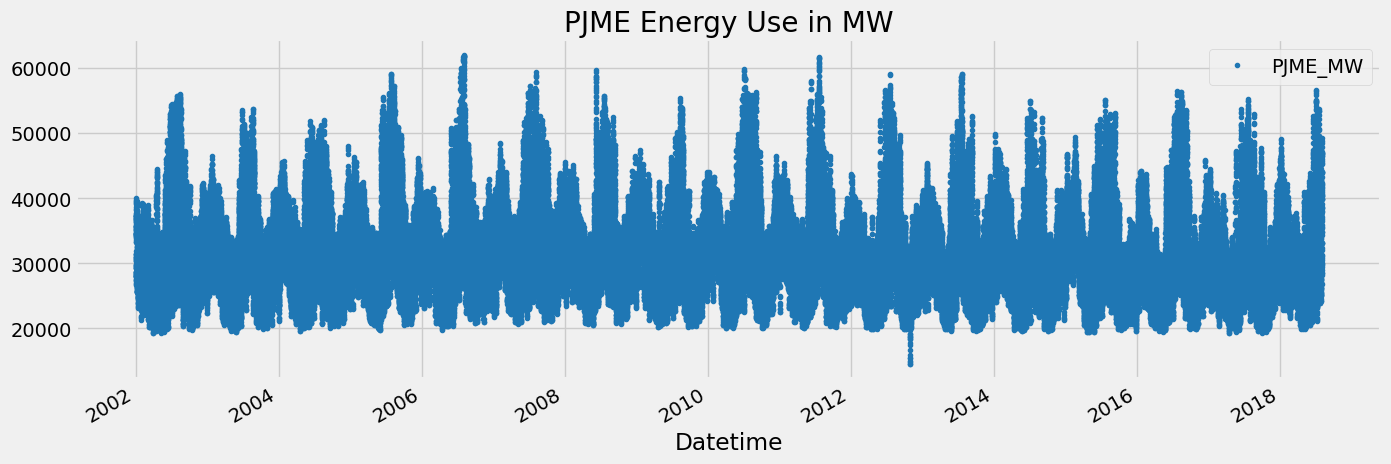

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

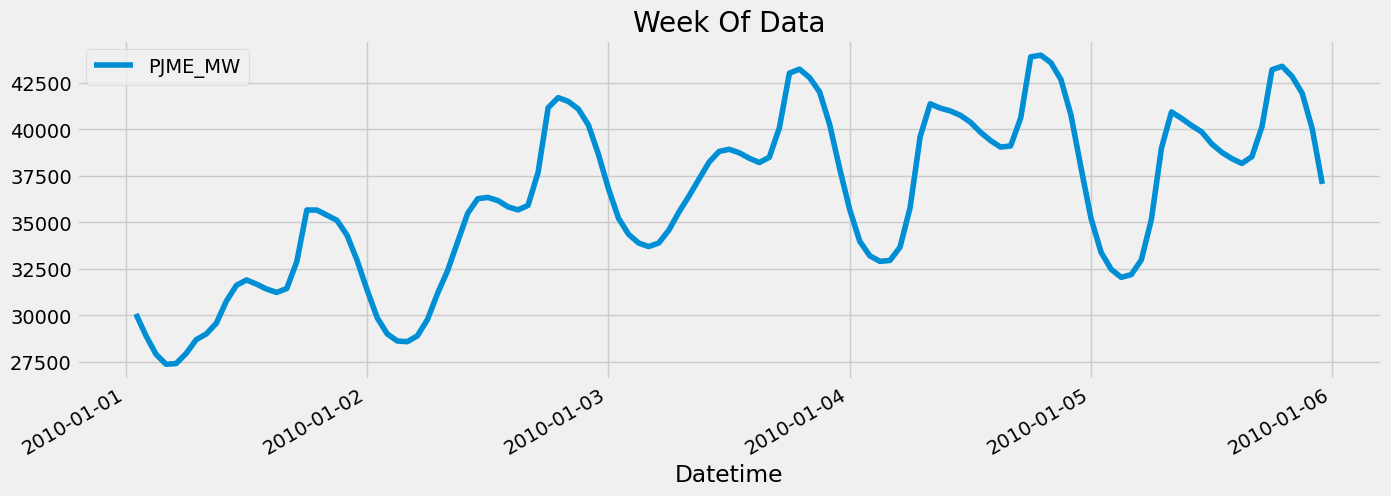

In [5]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-06-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

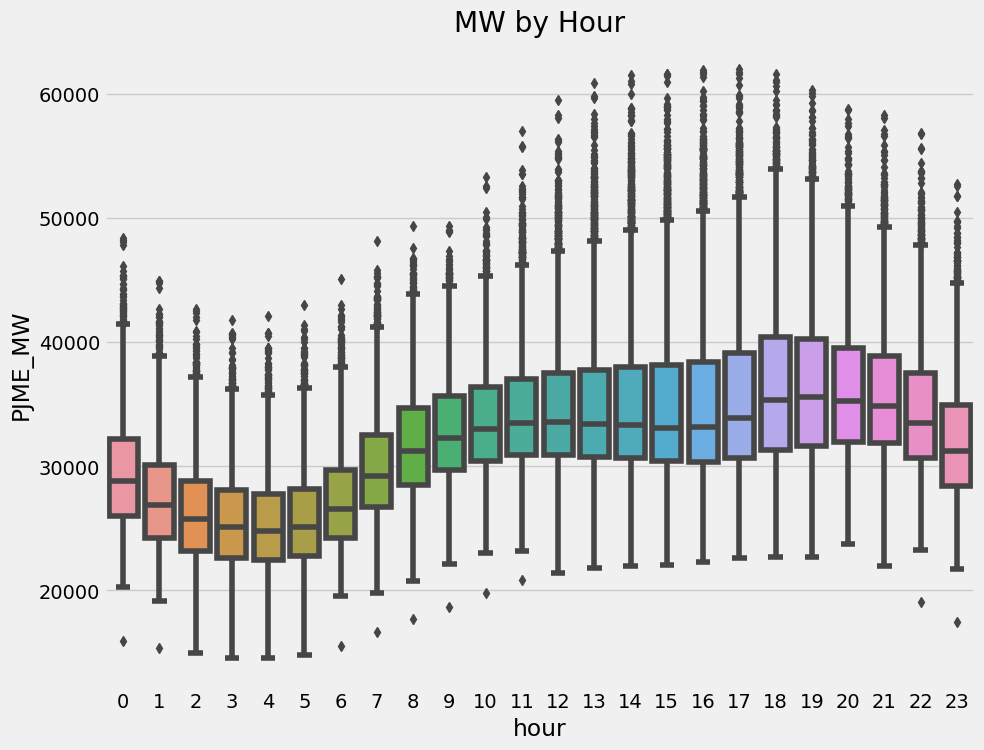

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

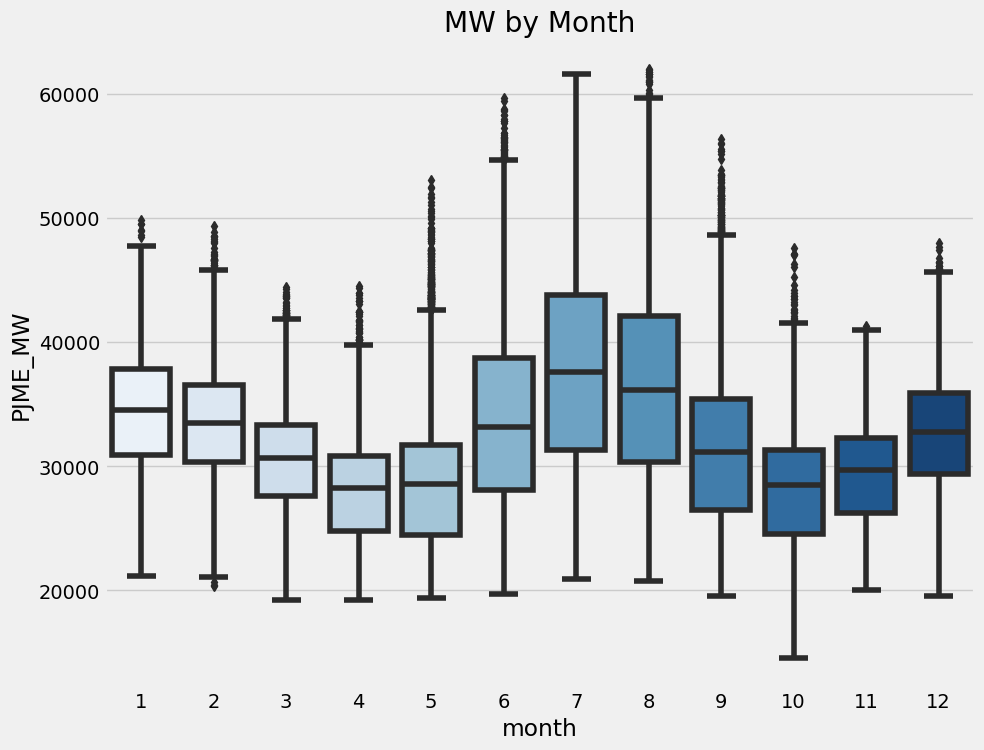

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Feature Engineering

In [8]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Train / Test Split

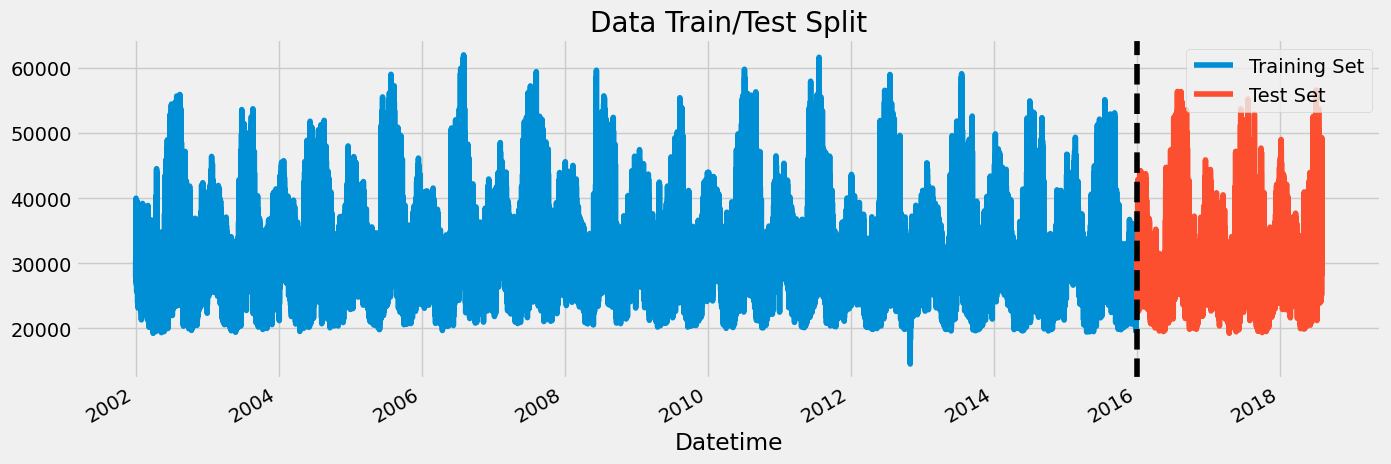

In [12]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

fig, ax = plt.subplots(figsize=(15, 5))
train['PJME_MW'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['PJME_MW'].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Model Selection

In [13]:
#train = create_features(train)
#test = create_features(test)
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

### Grid Search for XGBRegressor

In [17]:
from sklearn.model_selection import GridSearchCV

# Various hyper-parameters to tune
reg = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(reg,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[03:02:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[03:02:28] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

0.7096540413785033
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


### Cross Validation

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
model = xgb.XGBRegressor(colsample_bytree=0.7, learning_rate=0.03,max_depth=5,
                       min_child_weight=4, n_estimators=500, nthread=4, objective='reg:linear',
                       silent=1, subsample=0.7)


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: -1829.023 (12.341)


### Model Training

In [21]:
reg = xgb.XGBRegressor(colsample_bytree=0.7, learning_rate=0.03,max_depth=5,
                       min_child_weight=4, n_estimators=500, nthread=4, objective='reg:linear',
                       silent=1, subsample=0.7, early_stopping_rounds=50)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[03:09:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[03:09:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-rmse:31917.07037	validation_1-rmse:30847.46340
[100]	validation_0-rmse:3497.73953	validation_1-rmse:3949.99142
[168]	validation_0-rmse:2926.86489	validation_1-rmse:3953.98404


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,
             objective='reg:linear', ...)

## Feature Importance

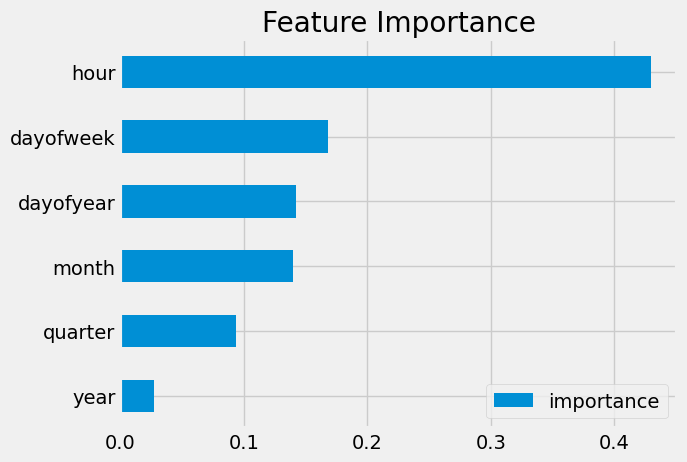

In [22]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Test the model

<ipython-input-23-65792fa6baae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


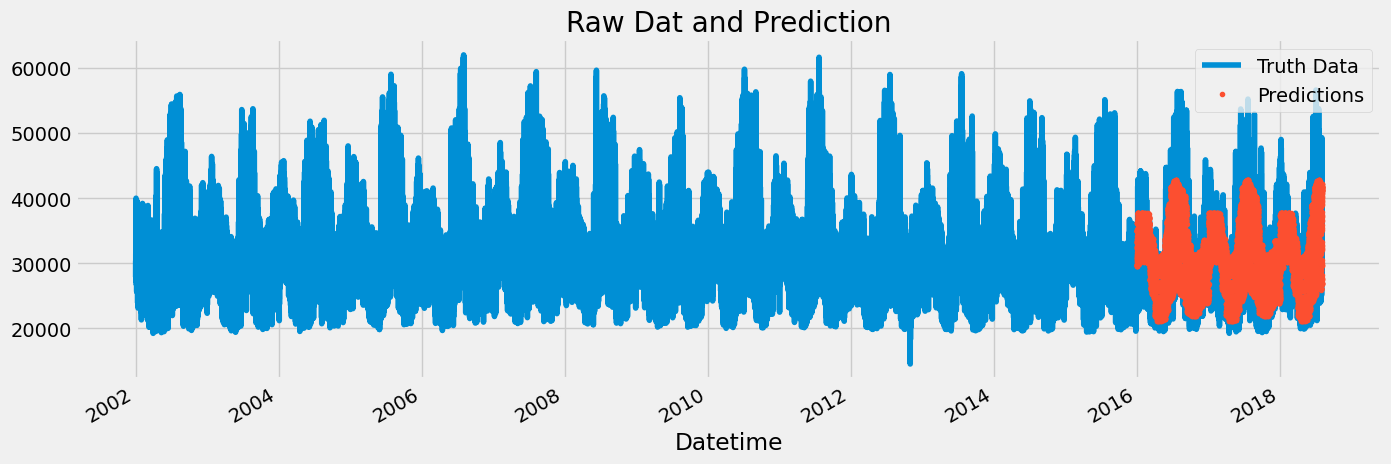

In [23]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

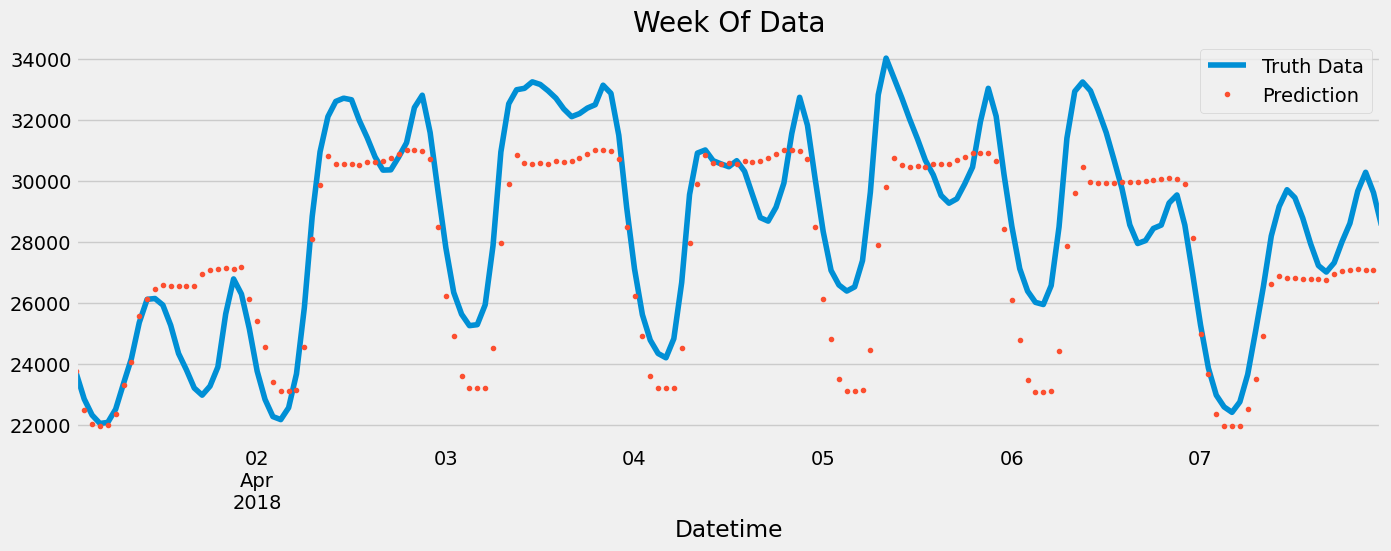

In [24]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Evaluate the model

In [30]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3899.73


Lets see the worst predictions

In [31]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13176.285726
2016-08-14    12723.246419
2016-09-10    12236.613525
2017-12-31    11230.554443
2016-08-12    10918.130452
2017-12-28    10777.235596
2016-09-09    10693.586426
2018-01-06    10665.737793
2017-12-29    10452.298177
2016-12-16    10300.971436
Name: error, dtype: float64

Lets see the best predictions

In [35]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2017-05-02    446.916341
2018-05-22    483.757161
2016-11-09    534.420247
2016-12-03    537.135742
2018-05-17    541.577637
2017-12-05    557.361247
2016-05-01    564.197917
2017-11-02    594.861816
2016-01-12    597.763265
2016-06-03    626.658447
Name: error, dtype: float64